# Time for Time series and its ups and downs

This competition made me change the vision of my notebook several times. From going between ARIMA, transformers, LSTM to LGBM, after each new discussion topic or a breakthrough. Instead of striving for just the results i decided to put in some of the things I tried out (with many more left to do) along the way, as well as the thought process behind it. Primary focus of this notebook became the exploration how the country of origin affects the imputation process and its outcomes.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import missingno as msno
import optuna

from datetime import datetime
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold, GroupKFold
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import FunctionTransformer
from numpy.polynomial import Polynomial
from scipy.optimize import minimize
import warnings

In [2]:
warnings.filterwarnings("ignore")

In [3]:
!pip install wbgapi

import wbgapi as wb

In [4]:
df_train = pd.read_csv('/kaggle/input/playground-series-s5e1/train.csv')

df_test = pd.read_csv('/kaggle/input/playground-series-s5e1/test.csv')

In [5]:
df_train.head()

,id,date,country,store,product,num_sold
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0


In [6]:
# Percentages of missing rows per column
df_train.isna().mean().mul(100)

id          0.000000
date        0.000000
country     0.000000
store       0.000000
product     0.000000
num_sold    3.854778
dtype: float64

**What's the cause of missing values?**

In [7]:
df_train[df_train['num_sold'].isna()].head()

,id,date,country,store,product,num_sold
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN
45,45,2010-01-01,Kenya,Discount Stickers,Holographic Goose,NaN
90,90,2010-01-02,Canada,Discount Stickers,Holographic Goose,NaN
135,135,2010-01-02,Kenya,Discount Stickers,Holographic Goose,NaN
180,180,2010-01-03,Canada,Discount Stickers,Holographic Goose,NaN


In [8]:
#Checking what combinations are related to missing num_sold
df_miss = df_train.drop(['id', 'date'], axis = 1)

unique_col_values = df_miss.loc[df_miss.iloc[:, -1].isna(), df_miss.columns[:-1]].drop_duplicates()

print(unique_col_values)

       country                 store             product
0       Canada     Discount Stickers   Holographic Goose
45       Kenya     Discount Stickers   Holographic Goose
320      Kenya     Stickers for Less   Holographic Goose
505      Kenya  Premium Sticker Mart   Holographic Goose
545     Canada     Stickers for Less   Holographic Goose
1128     Kenya     Discount Stickers            Kerneler
8110    Canada  Premium Sticker Mart   Holographic Goose
23719    Kenya     Discount Stickers  Kerneler Dark Mode
207003  Canada     Discount Stickers            Kerneler


In [9]:
gp = df_miss[df_miss.iloc[:, -1].isna()].groupby(['country', 'store', 'product'])
gp.count().rsub(gp.size(), axis=0)

num_sold
country store                product                     
Canada  Discount Stickers    Holographic Goose       2557
                             Kerneler                   1
        Premium Sticker Mart Holographic Goose        380
        Stickers for Less    Holographic Goose       1308
Kenya   Discount Stickers    Holographic Goose       2557
                             Kerneler                  63
                             Kerneler Dark Mode         1
        Premium Sticker Mart Holographic Goose        646
        Stickers for Less    Holographic Goose       1358

In [10]:
for i in range(3):
    print(df_train.iloc[:, i+2].unique())

['Canada' 'Finland' 'Italy' 'Kenya' 'Norway' 'Singapore']
['Discount Stickers' 'Stickers for Less' 'Premium Sticker Mart']
['Holographic Goose' 'Kaggle' 'Kaggle Tiers' 'Kerneler'
 'Kerneler Dark Mode']


In [11]:
def date_extractor(df):
    df['date'] = pd.to_datetime(df['date'])
    df['Year'] = df['date'].dt.year
    df['Day'] = df['date'].dt.day
    df['Month'] = df['date'].dt.month
    df['Weekday'] = df['date'].dt.weekday+1
    df['Day Of Year'] = df['date'].dt.dayofyear
    df['Group'] = (df['Year'] - 2010) * 48 + df['Month'] * 4 + df['Day'] // 7
    
    return df

In [12]:
df_train = date_extractor(df_train)

# Visualising trends, similarities and differences

Since this competition is similar to the [Tabular Playground Series from September 2022](https://www.kaggle.com/competitions/tabular-playground-series-sep-2022) I wanted to recreate a plotting function I made but this time in Python instead of R.

The arguments remained mostly the same thus I'm going to copy the description:

grouping_plotter(dataset, group_list, groupby_time, groupdistinct) - function that allows the choice and grouping of plotted variables:

* **df** - data.frame object

* **group_list** - list of vectors with variable names (e.g. for this competition):

* **country** - whether to plot number of sold books based on the country ('Canada', 'Finland', 'Italy', 'Kenya', 'Norway', 'Singapore')

* **store** - whether to plot number of sold books based on the store ('Discount Stickers', 'Stickers for Less', 'Premium Sticker Mart')

* **product** - whether to plot how well a particular product is selling ('Holographic Goose', 'Kaggle', 'Kaggle Tiers', 'Kerneler', 'Kerneler Dark Mode')

* **groupby_time** - grouping based on the time of the year e.g.:

* **Weekday** - mean of each 'day-of-the-week' throughout the series

* **Day** - mean of each day throughout '30' / '31' day months in the series

* **Month** - mean of each month in a year

* **Year** - mean of each year


* **groupdistinct** - which groups should be the focal point of the plot and what distinction to draw between them - first element decides the division between subgroups

* **makegrid** - to compare two groups in a grid, instead of a single plot - makegrid uses groups from groupdistinct argument. Moreover the order of groups in the groupdistinct argument dictates the layout of the grid - first element will be treated as rows and second as columns.

* **scale** - to scale values (0-1 scale) by groupping them by the first element of groupdistinct and dividing num_sold_mean by its max value for the specific group - e.g. num_sold_mean of each country gets scaled by the maximum num_sold_mean of a chosen time period

* **title** - whether to add a title to the plot and what it should be

In [13]:
def grouping_plotter(df, group_list, groupby_time, groupdistinct, makegrid=None, scale=False, title = None):
    
    df = df.dropna(axis = 0)
    
    # Filtering chosen variables
    for i in range(3):
        df = df[df.iloc[:, i].isin(group_list[i])]
    
    # Changing character variables into categorical
    df.iloc[:, :3] = df.iloc[:, :3].astype('category')


    # Grouping variables and calculating mean of num_sold    
    df['num_sold_mean'] = df.groupby([groupby_time] + groupdistinct)['num_sold'].transform('mean')
    
    # Scaling num_sold_mean based on first element of groupdistinct by its max value (0-1 scale)
    if(scale == True):
        df['num_sold_mean'] = df.groupby(groupdistinct[0])['num_sold_mean'].transform(lambda x: x / x.max())
    

    
    sns.set(font_scale=2.5)  
    sns.set_theme(style="whitegrid")
    if makegrid is None or not makegrid:
        # Creating a joint grouping variable
        df['grouping'] = df[groupdistinct].astype(str).agg('_'.join, axis=1)
        df = df.sort_values('grouping').drop_duplicates(subset='num_sold_mean')
        

        plt.figure(figsize=(14, 8))
        sns.lineplot(
            data=df, 
            x=groupby_time, 
            y='num_sold_mean', 
            hue='grouping',
            linewidth=1.75
        )
        plt.grid(color='gray', alpha=0.75)
        plt.xticks(fontsize=12, rotation=45)
        plt.yticks(fontsize=12)
        plt.xlabel(groupby_time.replace('_', ' ').title(), fontsize=14)
        plt.ylabel('Mean Num Sold', fontsize=14)
        plt.legend(
            title='Grouping', 
            fontsize=12, 
            title_fontsize=14, 
            loc='upper right',  
            bbox_to_anchor=(1.20, 1)  
        )
        if title:
              plt.title(title, fontsize=16, y=1.05)
        plt.show()
    
    elif makegrid:
        # Removing unnecessary data
        df = df[[groupby_time] + groupdistinct + ['num_sold_mean']].drop_duplicates()
        
        
        g = sns.FacetGrid(
            df, 
            col=groupdistinct[1], 
            row=groupdistinct[0], 
            margin_titles=True,
            hue = groupdistinct[1],
            height=4.5, 
            aspect=1.5
        )
        g.map_dataframe(
            sns.lineplot, 
            x=groupby_time, 
            y='num_sold_mean', 
            linewidth=3.4
        )
        
        g.set_axis_labels(groupby_time.replace('_', ' ').title(), 'Mean Num Sold', fontsize = 14)
        g.set_titles(col_template='{col_name}', row_template='{row_name}')
        g.tick_params(axis='x', which='both', rotation=45)
        g.add_legend(title=groupdistinct[1], fontsize=16, title_fontsize=18)
        
        if title:
            g.fig.suptitle(title, fontsize=22, y = 1.025)
        
        plt.show()

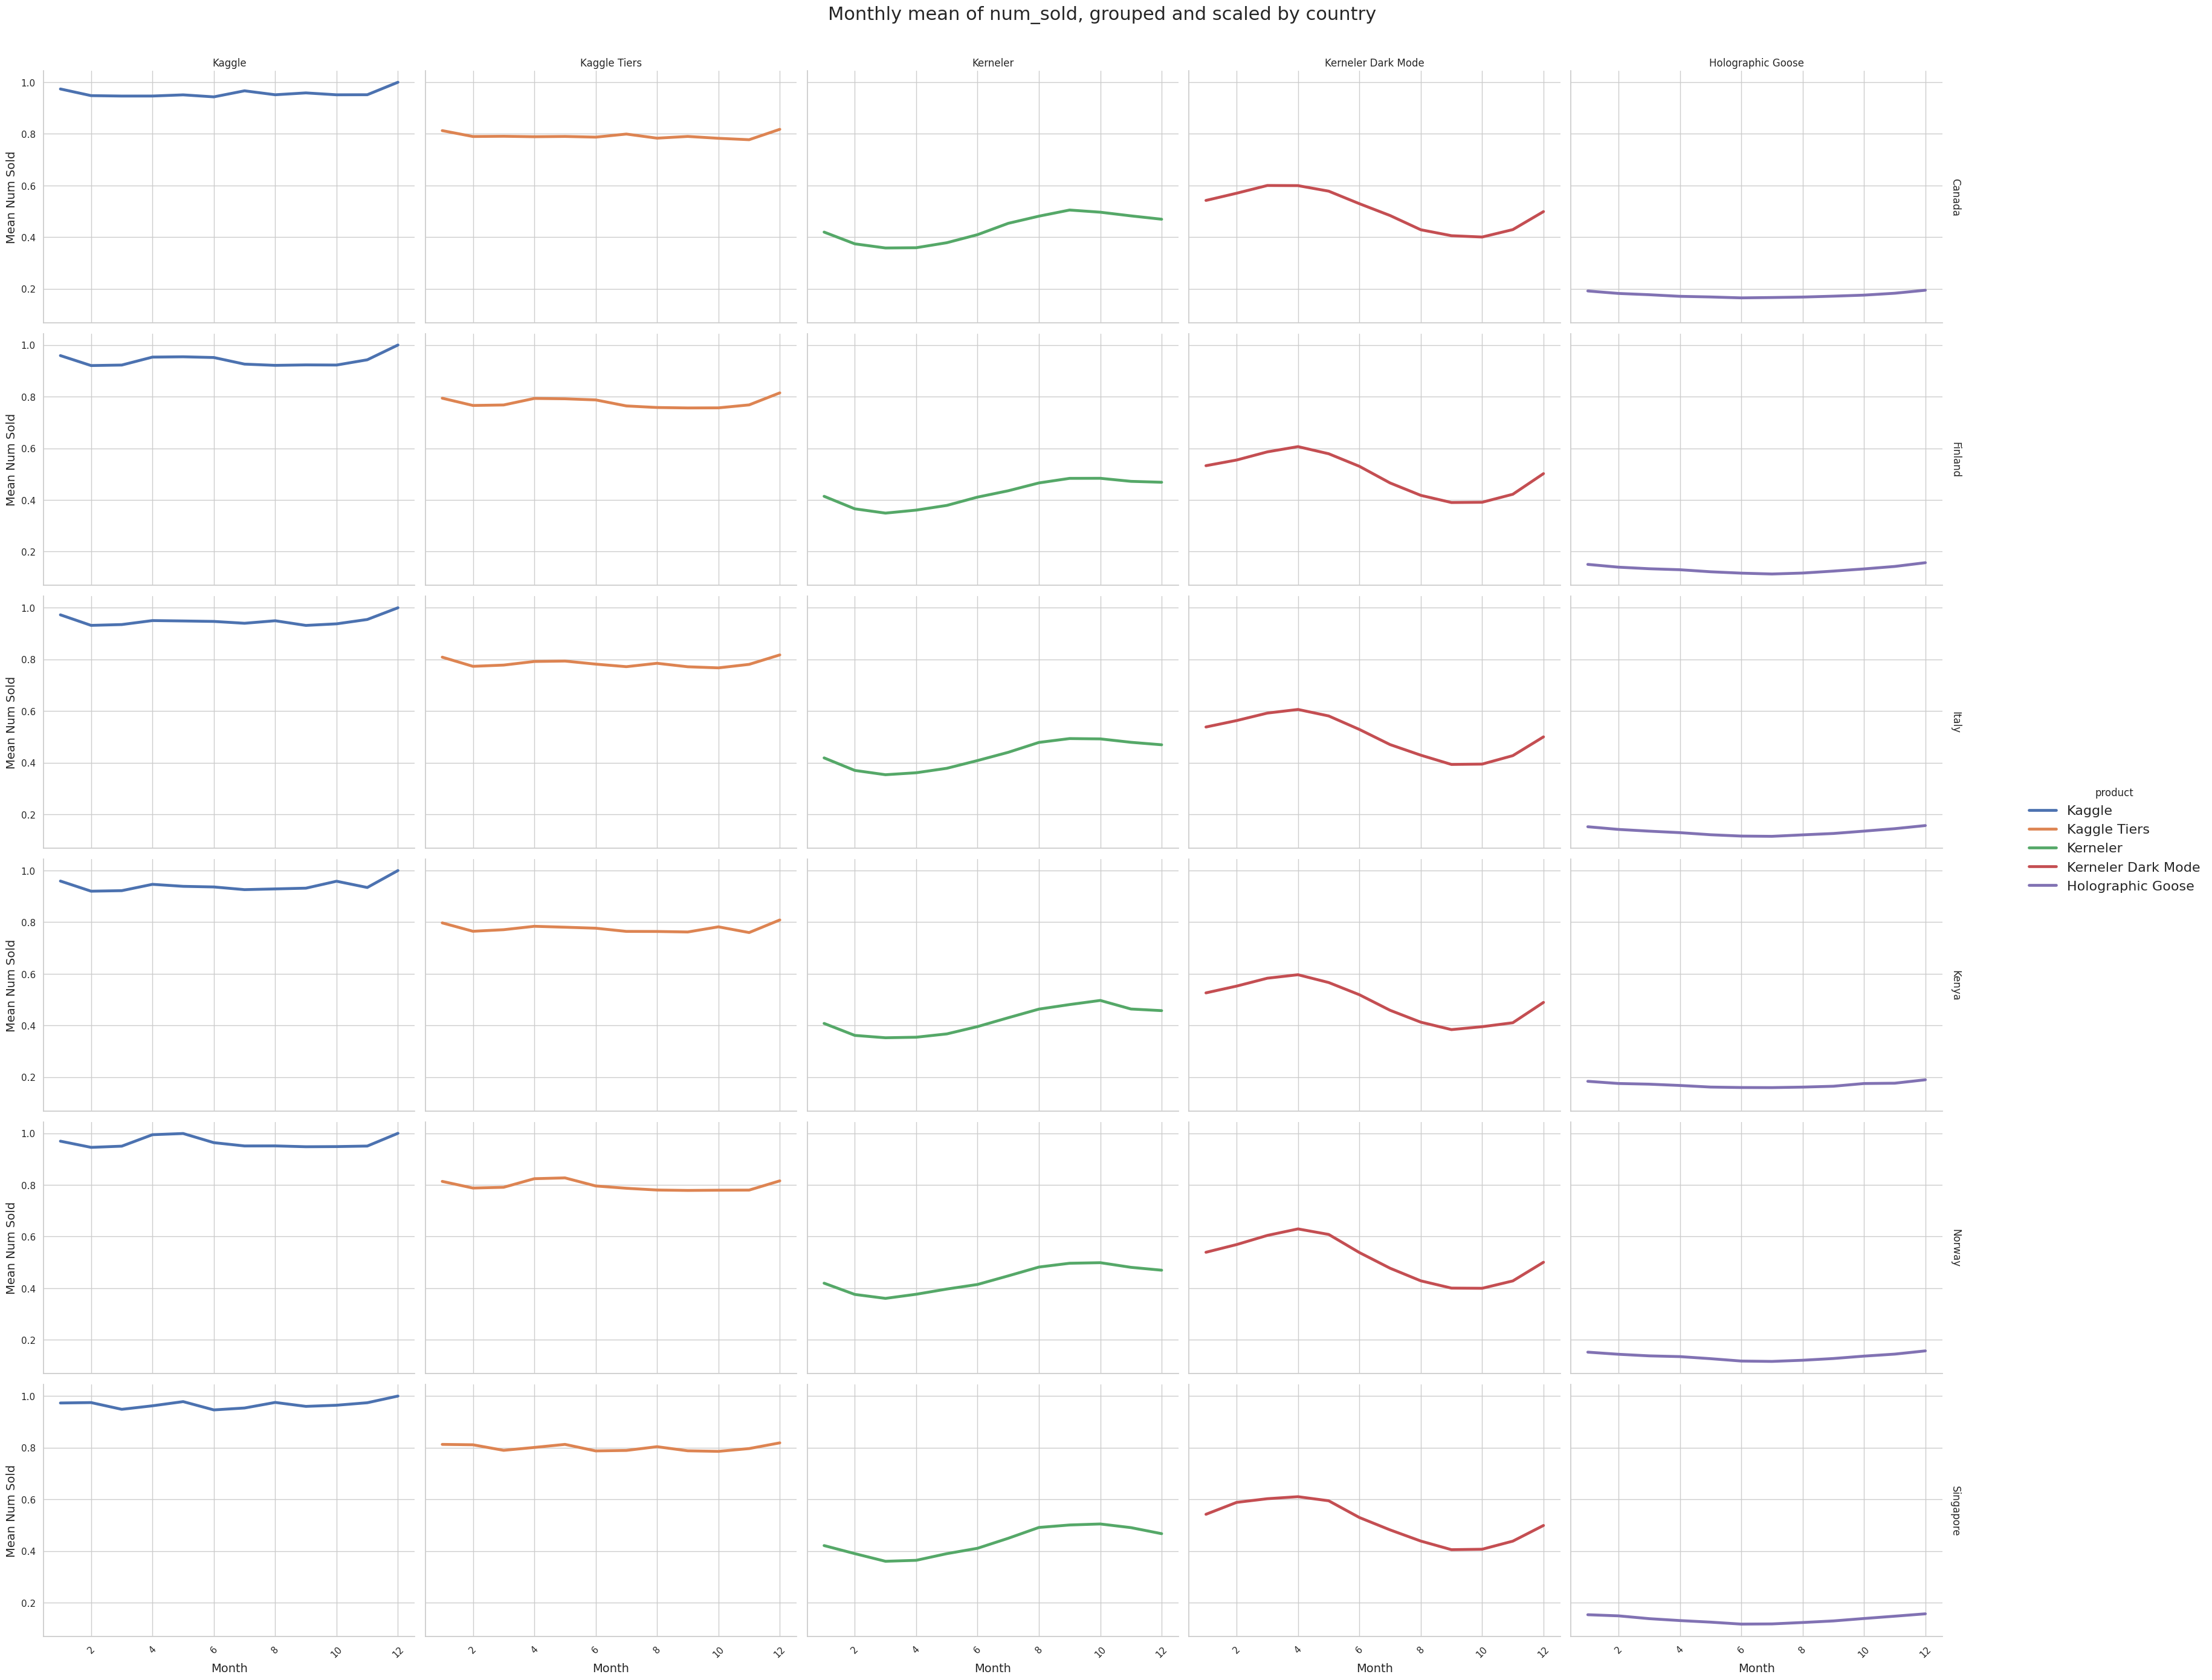

In [14]:
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

grouping_plotter(df_train.iloc[:, 2:11],
                group_list = [['Canada', 'Finland', 'Italy', 'Kenya', 'Norway', 'Singapore'],
                             ['Discount Stickers', 'Stickers for Less', 'Premium Sticker Mart'],
                             ['Holographic Goose', 'Kaggle', 'Kaggle Tiers', 'Kerneler', 'Kerneler Dark Mode']],
                groupby_time = 'Month',
                groupdistinct = ['country', 'product'],
                makegrid = True,
                scale = True,
                title = "Monthly mean of num_sold, grouped and scaled by country")

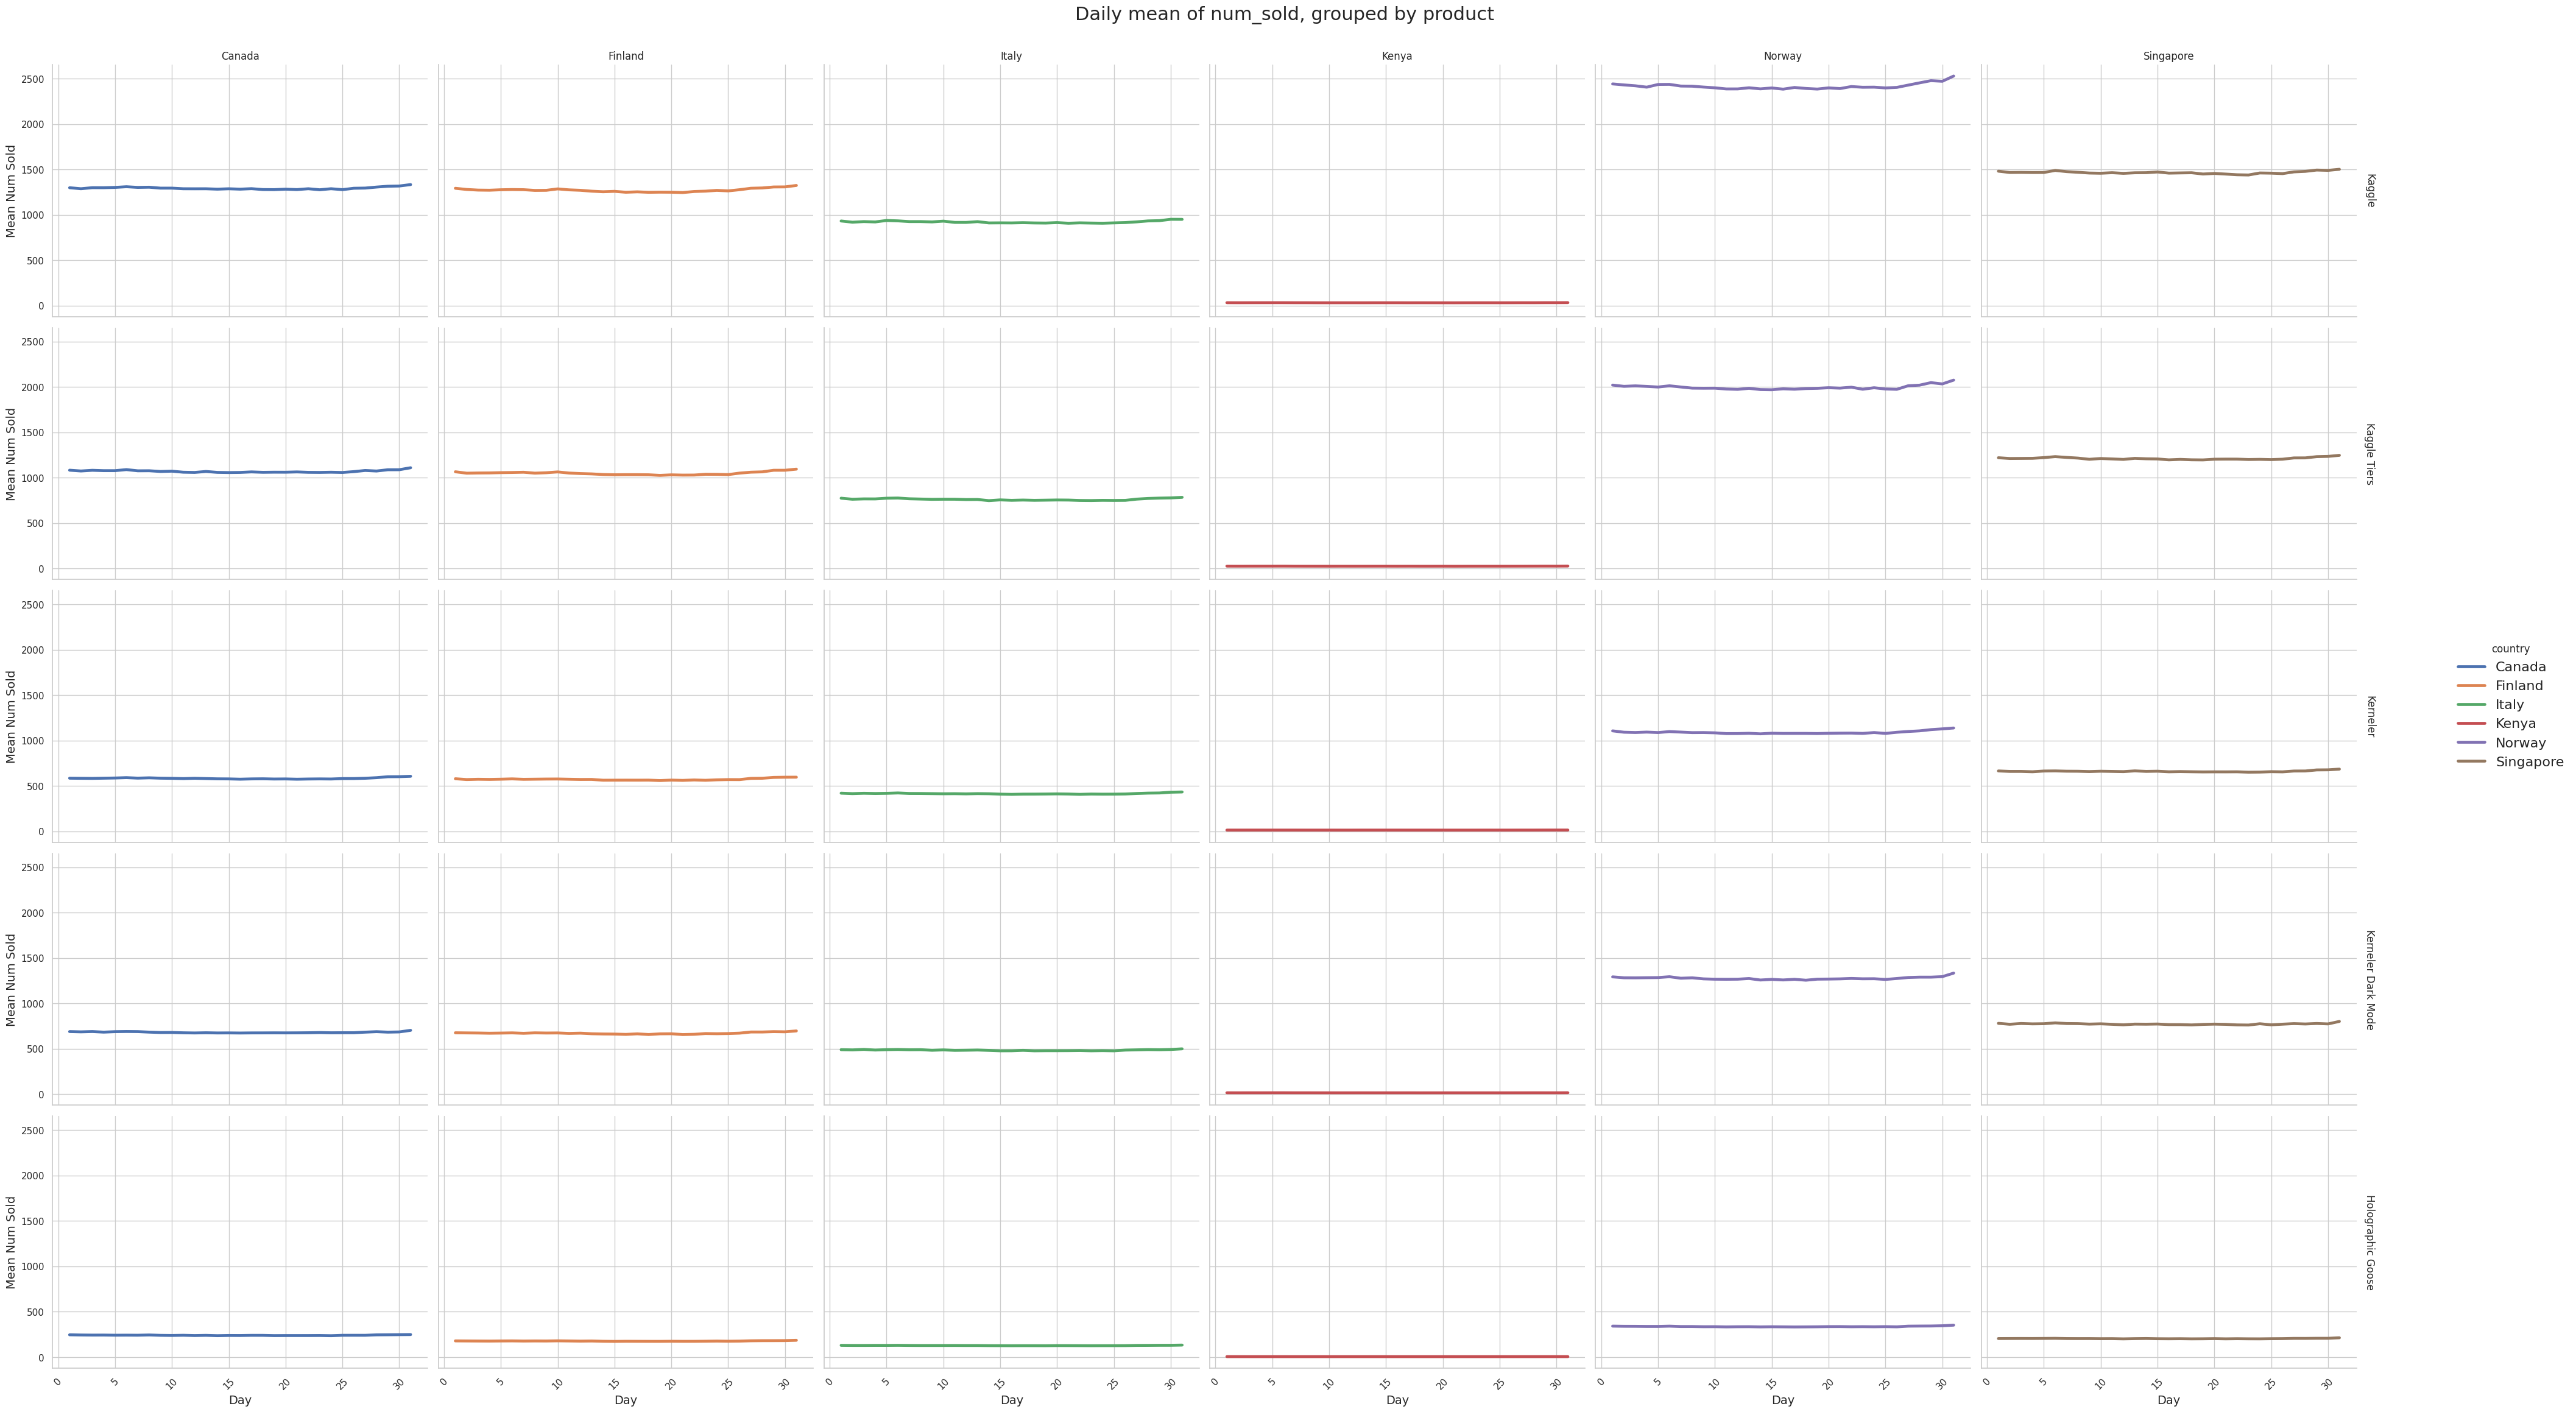

In [15]:
grouping_plotter(df_train.iloc[:, 2:11],
                group_list = [['Canada', 'Finland', 'Italy', 'Kenya', 'Norway', 'Singapore'],
                             ['Discount Stickers', 'Stickers for Less', 'Premium Sticker Mart'],
                             ['Holographic Goose', 'Kaggle', 'Kaggle Tiers', 'Kerneler', 'Kerneler Dark Mode']],
                groupby_time = 'Day',
                groupdistinct = ['product','country'],
                makegrid = True,
                scale = False,
                title = "Daily mean of num_sold, grouped by product")

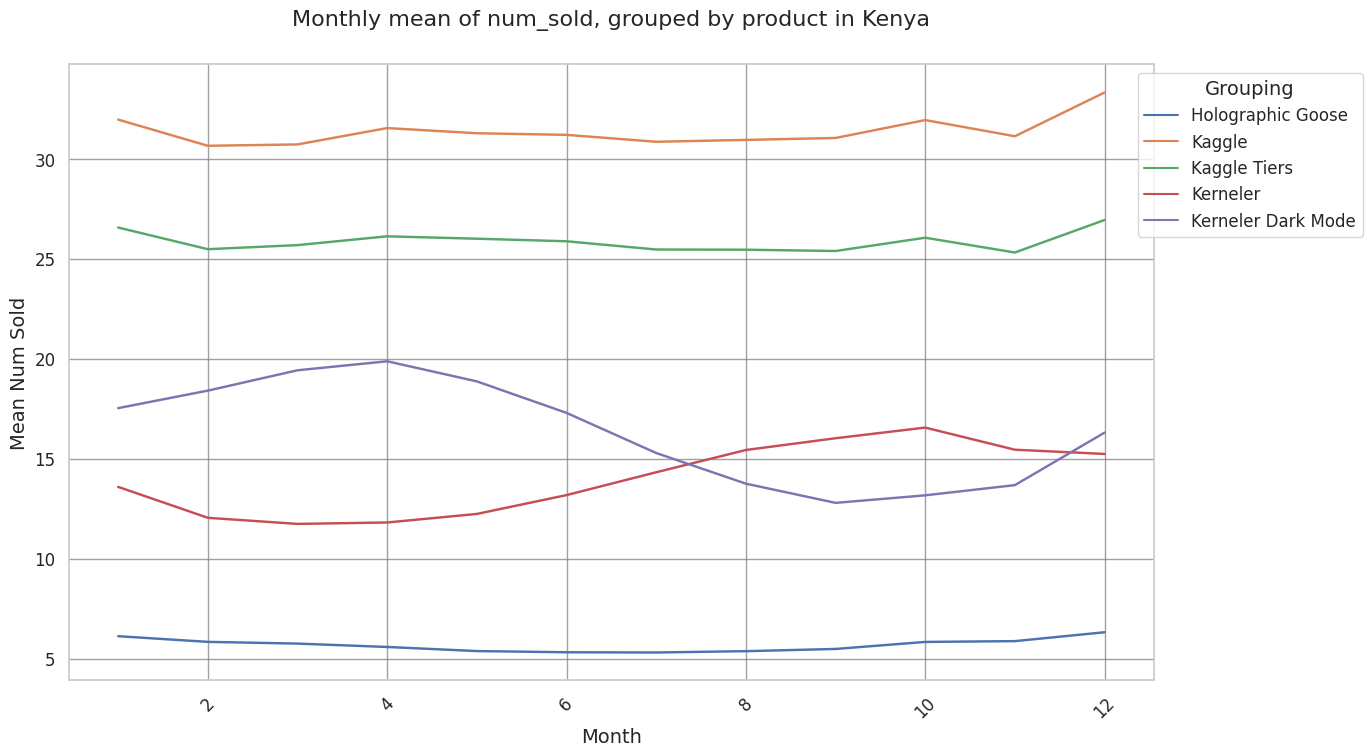

In [16]:
grouping_plotter(df_train.iloc[:, 2:11],
                group_list = [['Kenya'],
                             ['Discount Stickers', 'Stickers for Less', 'Premium Sticker Mart'],
                             ['Holographic Goose', 'Kaggle', 'Kaggle Tiers', 'Kerneler', 'Kerneler Dark Mode']],
                groupby_time = 'Month',
                groupdistinct = ['product'],
                makegrid = False,
                title = 'Monthly mean of num_sold, grouped by product in Kenya')

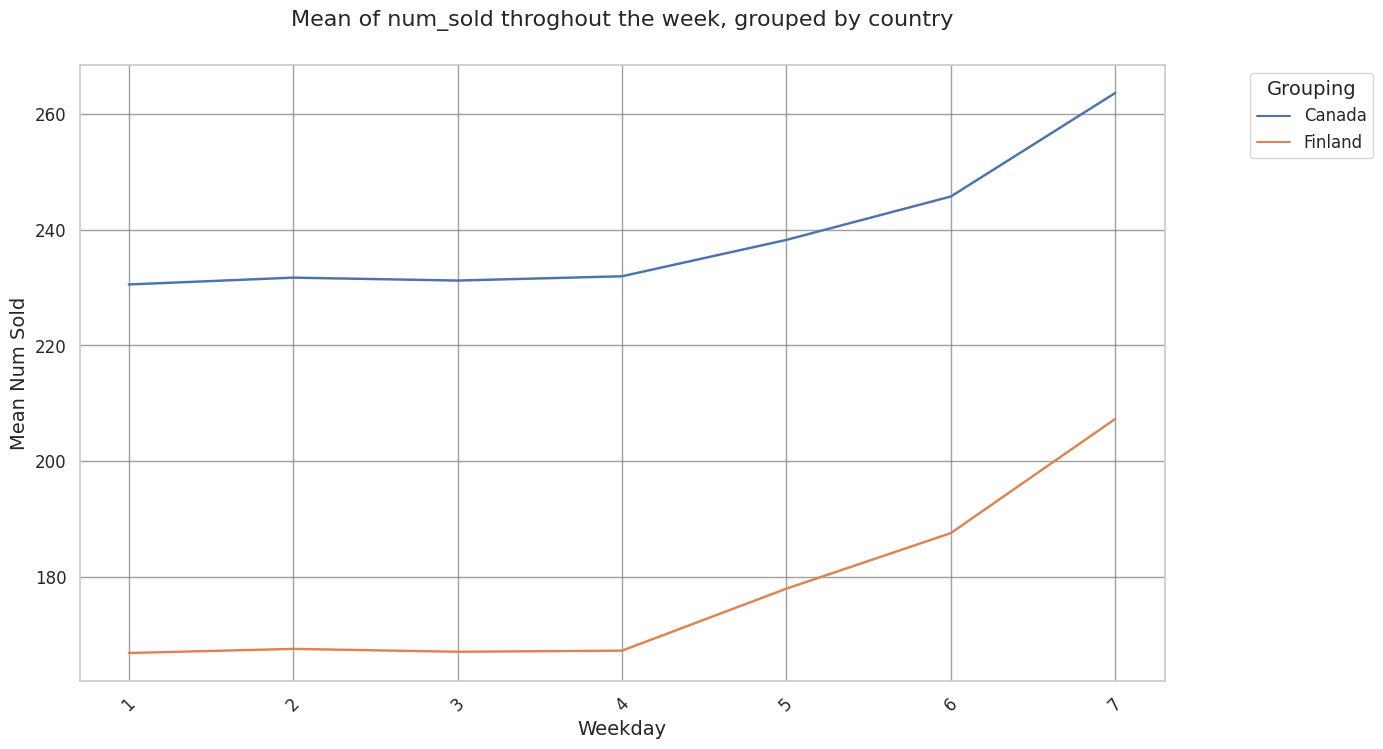

In [17]:
grouping_plotter(df_train.iloc[:, 2:11],
                group_list = [['Finland', 'Canada'],
                             ['Discount Stickers', 'Stickers for Less', 'Premium Sticker Mart'],
                             ['Holographic Goose']],
                groupby_time = 'Weekday',
                groupdistinct = ['country'],
                makegrid = False,
                title = 'Mean of num_sold throghout the week, grouped by country')

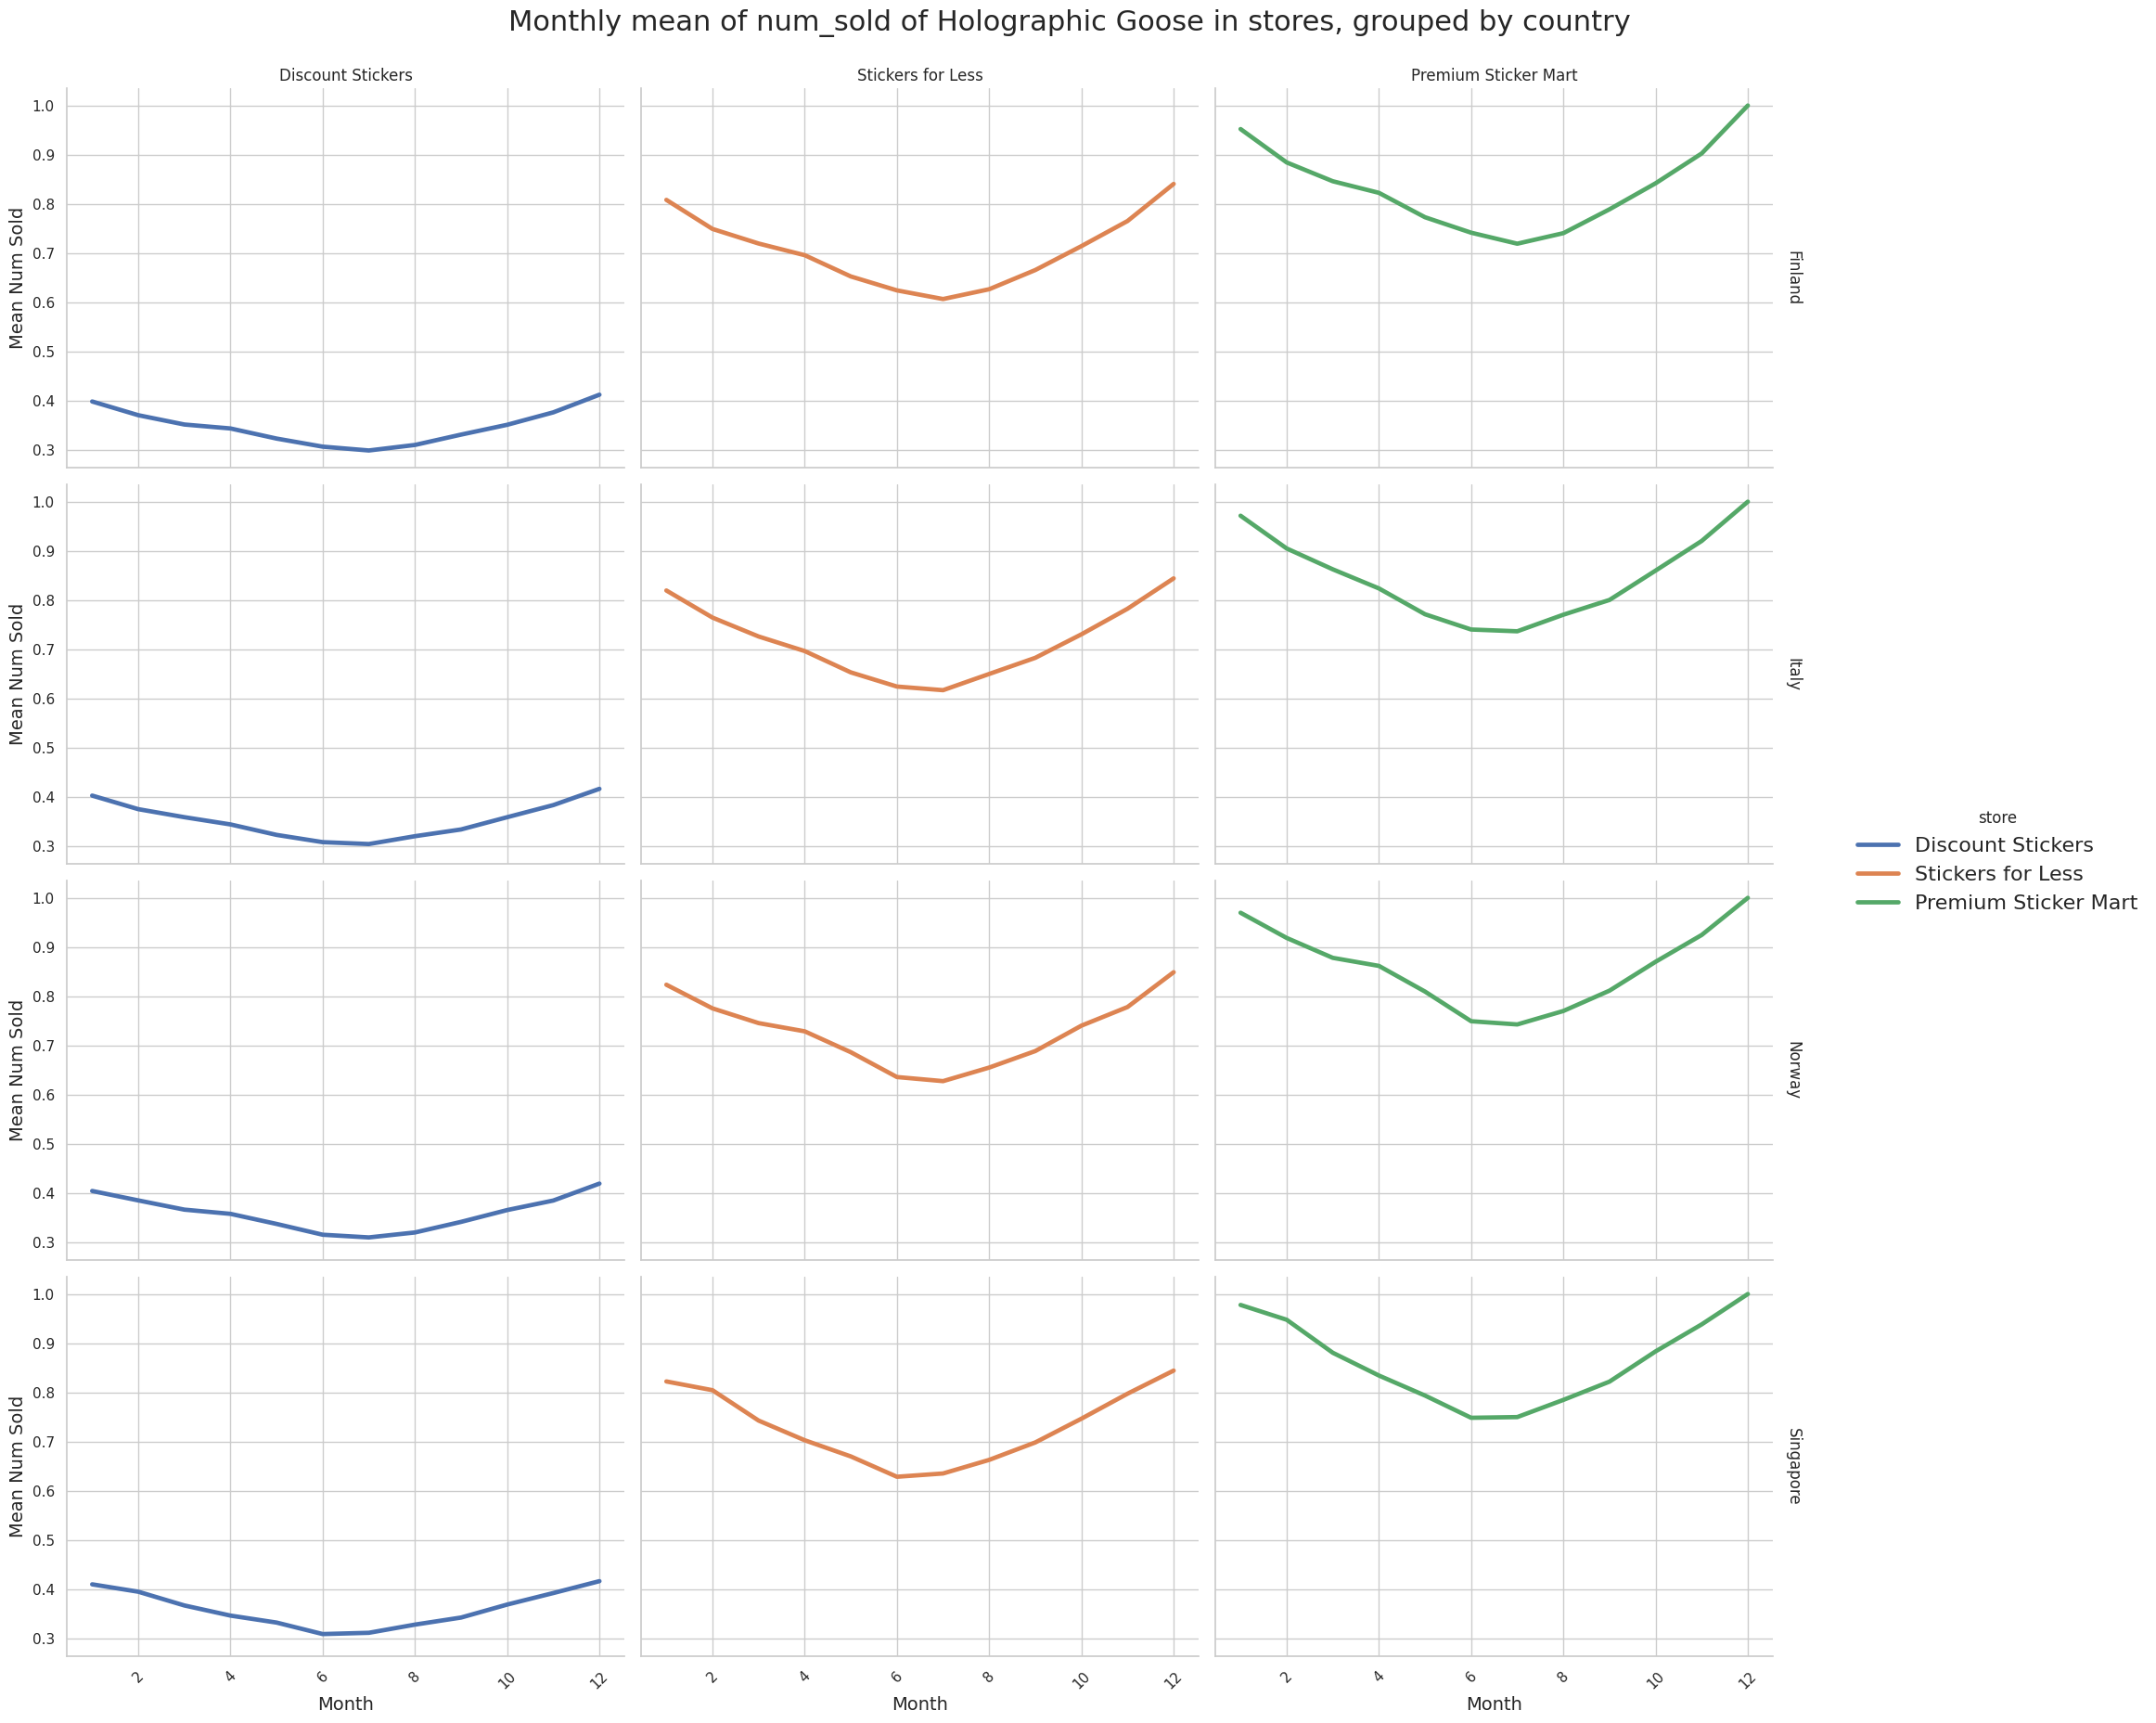

In [18]:
grouping_plotter(df_train.iloc[:, 2:11],
                group_list = [['Finland', 'Italy', 'Norway', 'Singapore'],
                             ['Discount Stickers', 'Stickers for Less', 'Premium Sticker Mart'],
                             ['Holographic Goose']],
                groupby_time = 'Month',
                groupdistinct = ['country', 'store'],
                makegrid = True,
                scale = True,
                title = 'Monthly mean of num_sold of Holographic Goose in stores, grouped by country')

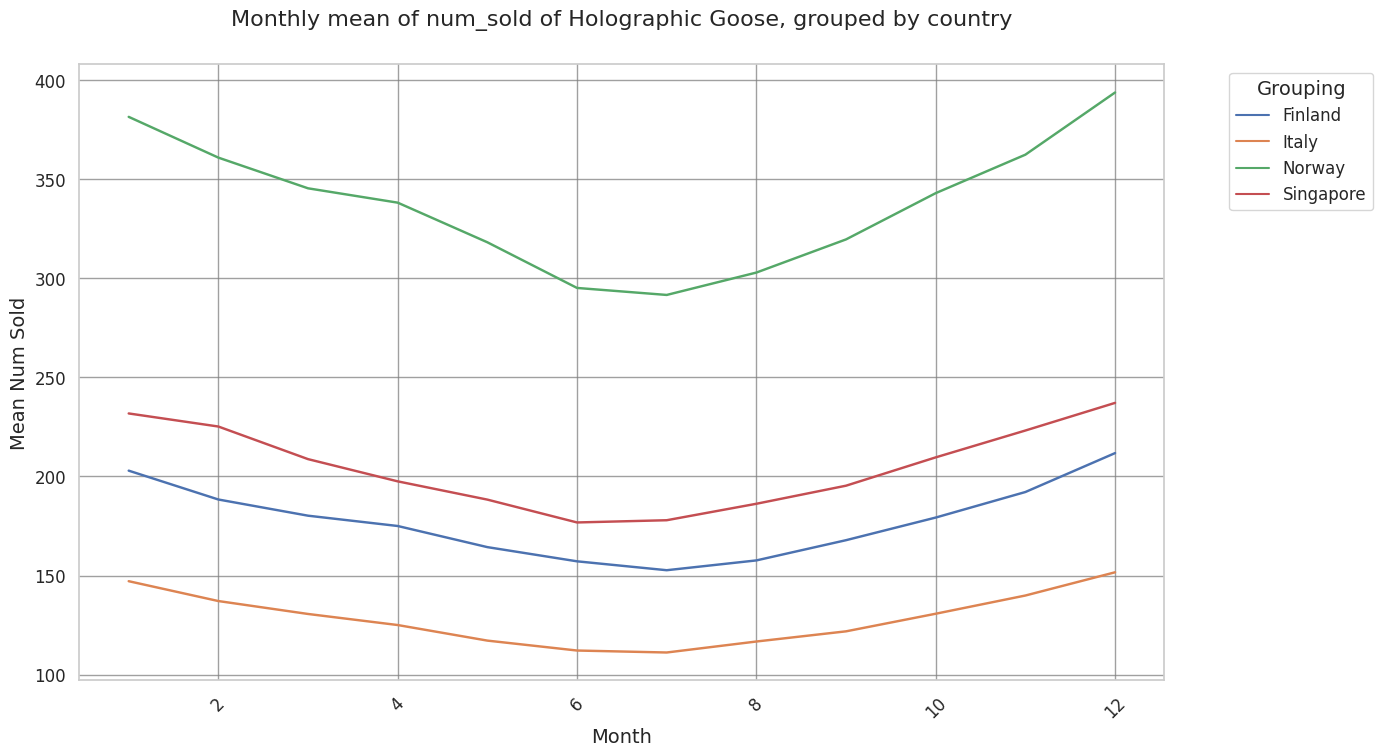

In [19]:
grouping_plotter(df_train.iloc[:, 2:11],
                group_list = [['Finland', 'Italy', 'Norway', 'Singapore'],
                             ['Discount Stickers', 'Stickers for Less', 'Premium Sticker Mart'],
                             ['Holographic Goose']],
                groupby_time = 'Month',
                groupdistinct = ['country'],
                makegrid = None,
                scale = False,
                title = 'Monthly mean of num_sold of Holographic Goose, grouped by country')

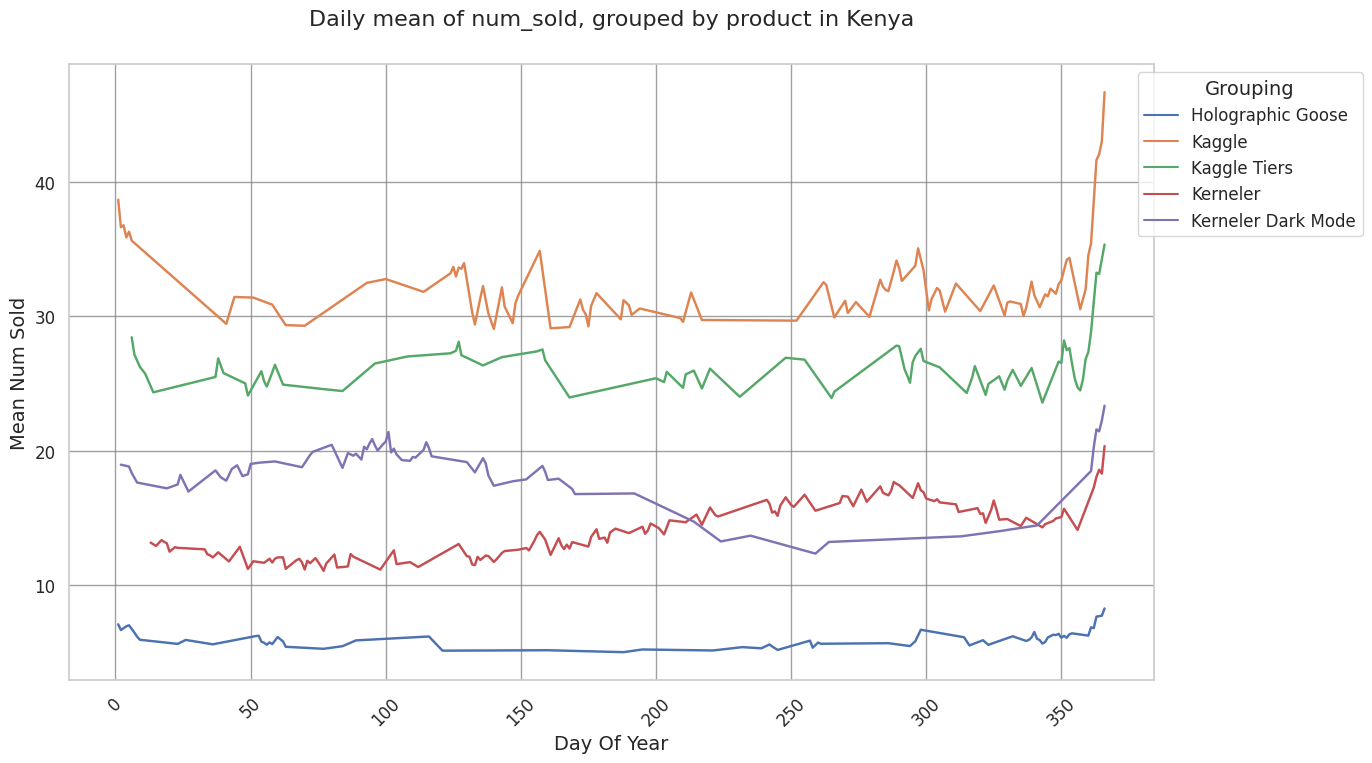

In [20]:
grouping_plotter(df_train.iloc[:, 2:11],
                group_list = [['Kenya'],
                             ['Discount Stickers', 'Stickers for Less', 'Premium Sticker Mart'],
                             ['Holographic Goose', 'Kaggle', 'Kaggle Tiers', 'Kerneler', 'Kerneler Dark Mode']],
                groupby_time = 'Day Of Year',
                groupdistinct = ['product'],
                makegrid = False,
                title = 'Daily mean of num_sold, grouped by product in Kenya')

**GDP data as another feature**

Adding GDP as a feature since there is available data for the test set. Nevertheles it is annual data, so a lot of information is lost.

In [21]:
df_gdp = wb.data.DataFrame('NY.GDP.PCAP.CD', 
                       ['CAN', 'FIN', 'ITA', 'KEN', 'NOR', 'SGP'],
                       time=range(2010, 2020, 1), labels=True)
df_gdp

,Country,YR2010,YR2011,YR2012,YR2013,YR2014,YR2015,YR2016,YR2017,YR2018,YR2019
economy,,,,,,,,,,,
SGP,Singapore,47236.683085,53891.457026,55547.555308,56967.425794,57564.802311,55645.606861,56899.918181,61162.097393,66840.637339,66081.719924
NOR,Norway,88163.208593,101221.813477,102175.919298,103553.840134,97666.695184,74809.965805,70867.360997,76131.838403,82792.842711,76430.588947
KEN,Kenya,1091.518731,1096.144998,1285.005362,1370.878852,1482.815663,1489.119598,1554.126103,1667.484472,1836.452755,1960.408089
ITA,Italy,36184.711870,38851.388134,35235.798906,35747.707953,35750.719750,30387.129319,31126.324695,32554.146685,34746.344139,33812.788725
FIN,Finland,46506.291902,51060.324259,47551.674084,49691.014520,50073.776082,42560.345677,43451.256244,46085.017474,49654.249704,48358.180777
CAN,Canada,47560.666601,52223.858840,52670.344734,52638.118724,50960.843117,43594.194105,42314.061582,45129.628117,46539.176157,46352.869345


In [22]:
df_gdp_long = df_gdp.reset_index().melt(
    id_vars=['Country'],  
    var_name='Year',      
    value_name='GDP'      
)

df_gdp_long = df_gdp_long.rename(columns = {"Country":"country"})

df_gdp_long = df_gdp_long.iloc[6:]

# Removing YR prefix from Year column values
df_gdp_long['Year'] = [str(year)[2:] for year in df_gdp_long['Year']]

df_gdp_long['Year'] = df_gdp_long['Year'].astype(int)



df_train = df_train.merge(
    df_gdp_long,
    left_on = ['country', 'Year'],
    right_on=['country', 'Year'],   
    how='left'                    
)


df_train['GDP'] = df_train['GDP'].astype('float')

df_train

,id,date,country,store,product,num_sold,Year,Day,Month,Weekday,Day Of Year,Group,GDP
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN,2010,1,1,5,1,4,47560.666601
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0,2010,1,1,5,1,4,47560.666601
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0,2010,1,1,5,1,4,47560.666601
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0,2010,1,1,5,1,4,47560.666601
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0,2010,1,1,5,1,4,47560.666601
...,...,...,...,...,...,...,...,...,...,...,...,...,...
230125,230125,2016-12-31,Singapore,Premium Sticker Mart,Holographic Goose,466.0,2016,31,12,6,366,340,56899.918181
230126,230126,2016-12-31,Singapore,Premium Sticker Mart,Kaggle,2907.0,2016,31,12,6,366,340,56899.918181
230127,230127,2016-12-31,Singapore,Premium Sticker Mart,Kaggle Tiers,2299.0,2016,31,12,6,366,340,56899.918181
230128,230128,2016-12-31,Singapore,Premium Sticker Mart,Kerneler,1242.0,2016,31,12,6,366,340,56899.918181


In [23]:
def feature_encoder(df):
    def sin_transformer(period):
    	return FunctionTransformer(lambda x: np.sin(x* 2 * np.pi / period))

    def cos_transformer(period):
    	return FunctionTransformer(lambda x: np.cos(x * 2 * np.pi / period))


    df['Month Sin'] = sin_transformer(12).fit_transform(df["Month"])
    df['Day Sin'] = sin_transformer(365).fit_transform(df["Day Of Year"])
    df['Month Cos'] = cos_transformer(12).fit_transform(df["Month"])
    df['Day Cos'] = cos_transformer(365).fit_transform(df["Day Of Year"])
    df['Year Sin'] = sin_transformer(1).fit_transform(df["Year"])

    return df

In [24]:
df_train = feature_encoder(df_train)

df_train

,id,date,country,store,product,num_sold,Year,Day,Month,Weekday,Day Of Year,Group,GDP,Month Sin,Day Sin,Month Cos,Day Cos,Year Sin
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN,2010,1,1,5,1,4,47560.666601,5.000000e-01,0.017213,0.866025,0.999852,-1.370366e-13
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0,2010,1,1,5,1,4,47560.666601,5.000000e-01,0.017213,0.866025,0.999852,-1.370366e-13
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0,2010,1,1,5,1,4,47560.666601,5.000000e-01,0.017213,0.866025,0.999852,-1.370366e-13
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0,2010,1,1,5,1,4,47560.666601,5.000000e-01,0.017213,0.866025,0.999852,-1.370366e-13
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0,2010,1,1,5,1,4,47560.666601,5.000000e-01,0.017213,0.866025,0.999852,-1.370366e-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230125,230125,2016-12-31,Singapore,Premium Sticker Mart,Holographic Goose,466.0,2016,31,12,6,366,340,56899.918181,-2.449294e-16,0.017213,1.000000,0.999852,1.883434e-13
230126,230126,2016-12-31,Singapore,Premium Sticker Mart,Kaggle,2907.0,2016,31,12,6,366,340,56899.918181,-2.449294e-16,0.017213,1.000000,0.999852,1.883434e-13
230127,230127,2016-12-31,Singapore,Premium Sticker Mart,Kaggle Tiers,2299.0,2016,31,12,6,366,340,56899.918181,-2.449294e-16,0.017213,1.000000,0.999852,1.883434e-13
230128,230128,2016-12-31,Singapore,Premium Sticker Mart,Kerneler,1242.0,2016,31,12,6,366,340,56899.918181,-2.449294e-16,0.017213,1.000000,0.999852,1.883434e-13


# Filling missing data

Imputation of missing data threw me for a loop. Since I didn't want to probe the leaderboard to see if it actually improved the scores achieved by the model, some data had to be erased.
The training data was split to encompass two periods: 2010-2015 and 2016 as the test set. The data from 2010-2015 was used for both hyperparameter tuning, as well as tryout for imputation techniques.

I made some very slight changes to [@broccoli beef's](https://www.kaggle.com/siukeitin) nifty [code](https://www.kaggle.com/competitions/playground-series-s5e1/discussion/555500#3091632) that they posted in [@Konsantin Dimitriev's](https://www.kaggle.com/kdmitrie) highly informative discussion: [Separate analysis of predictions in different categories](https://www.kaggle.com/competitions/playground-series-s5e1/discussion/555500). I sincerely encourage to read the linked discussion (also shoutout to [@Spiritmilk](https://www.kaggle.com/act18l) for great input). Following [@Cabaxiom's](https://www.kaggle.com/cabaxiom) notebook [S5E1 EDA and Linear Regression Baseline ](https://www.kaggle.com/code/cabaxiom/s5e1-eda-and-linear-regression-baseline) logic I recreated, more or less, the quick way to fill in missing values and/or play around with normalized data.

In [25]:
# Separating 2016 as the test set
X_train = df_train.query('Year < 2016')
X_test = df_train.query('Year == 2016')

X_test = X_test.dropna()
X_test, y_test = X_test.drop('num_sold', axis = 1), X_test['num_sold']

A variation on [@broccoli beef's](https://www.kaggle.com/siukeitin) snippet of [code](https://www.kaggle.com/competitions/playground-series-s5e1/discussion/555500#3091632) made into a function.

In [26]:
def feature_normalizer(df):
    origin_df = df.copy()
    
    def poly_fit(x, y, a=1, b=1, deg=1):
        c0 = Polynomial.fit(x, y, deg).convert().coef
        res = minimize(
            lambda c: np.mean(np.abs(Polynomial(c)(x) - y) ** a / y ** b),
            c0, method='Nelder-Mead',
            options={'maxiter': 1000}
        )
        assert res.success
        return Polynomial(res.x)
    
    X = df.groupby(['Year', 'country'])[['num_sold']].sum().reset_index()

    # Merging data with GDP df
    X = X.merge(
        df_gdp_long, 
        on=['country', 'Year'],
        how='left'           
    )
    
    X['GDP'] = X['GDP'].astype('float')
    L = poly_fit(X['GDP'], X['num_sold'])
    X['L(GDP)'] = L(X['GDP'])
    
    
    X = X.join(X.groupby('Year')[['GDP', 'L(GDP)']].sum(), on='Year', rsuffix='_annual')
    for c in ['GDP', 'L(GDP)']:
        X[c] /= X[c+'_annual']
        X.pop(c+'_annual')
    X.pop('num_sold')
    
    df = df.groupby(['date', 'Year', 'country'])[['num_sold']].sum().reset_index().join(
        df.groupby(['date', 'Year'])[['num_sold']].sum(), on=['date', 'Year'],rsuffix='_global')
    
    df['num_sold'] /= df['num_sold_global']
    X = df.reset_index().groupby(['date', 'Year', 'country'])[['num_sold']].sum().reset_index().merge(X, on=['Year', 'country'])
    
    X = X.rename(columns = {"num_sold":"norm_num_sold", "GDP":"norm_GDP", "L(GDP)":"norm_L(GDP)"})

    origin_df = origin_df.merge(
        X,
        left_on = ['country', 'Year', 'date'],
        right_on=['country', 'Year', 'date'],   
        how='left'                    
    )
    
    return(origin_df)

I didn't utilise or expand this function's capabilities, but it could be easily used to see the effect and differences between using different countries of origin for imputation, as well as when (and how) to use normalised GDP and L(GDP).

In [27]:
def values_imputer(df, country_ref):
    df_country_ref = df[df.country == country_ref]
    df_country_ref = df_country_ref.rename(columns = {'num_sold':"ref_num_sold",
                                                     "norm_num_sold":"ref_norm_num_sold",
                                                     "norm_GDP":"ref_norm_GDP",
                                                     "norm_L(GDP)":"ref_norm_L(GDP)"})
    df_country_ref = df_country_ref.loc[:, ['date','store', 'product', 'ref_num_sold','ref_norm_num_sold', 'ref_norm_GDP','ref_norm_L(GDP)']]
    
    df = df.merge(
        df_country_ref,
        left_on = ['date', 'store', 'product'],
        right_on = ['date', 'store', 'product']
    )

    df['norm_num_sold_ratios'] = df['norm_num_sold'] / df['ref_norm_num_sold']
    df['norm_GDP_ratios'] = df['norm_GDP'] / df['ref_norm_GDP']
    df['norm_L(GDP)_ratios'] = df['norm_L(GDP)'] / df['ref_norm_L(GDP)']

    miss_mask = df['num_sold'].isna()

    df.loc[miss_mask, 'num_sold'] = (
        df.loc[miss_mask, 'ref_num_sold'] * df.loc[miss_mask, 'norm_num_sold_ratios']
    )

    #return(df.loc[miss_mask, 'num_sold'])
    return(df)

To check how well imputation performs and if filled data improves the overall score, I removed all *num_sold* of *Holographic Goose* from Italian *Discount Stickers*.

In [28]:
X_italy = X_train.query('country == "Italy" and product == "Holographic Goose" and store == "Discount Stickers"')

X_italy_missing = X_train.copy()

# Filling the data with NaNs
X_italy_missing.loc[X_italy.index,'num_sold'] = float('nan')

# Normalizing data
X_italy_missing = feature_normalizer(X_italy_missing)

# Checking how different countries to impute from affect MAPE
countries_ref = ['Finland', 'Singapore', 'Norway'] # Choosing countries without missing values
for i in countries_ref:

    italy_imputations = values_imputer(X_italy_missing, country_ref = i)

    little_italy = italy_imputations.query('country == "Italy" and product == "Holographic Goose" and store == "Discount Stickers"')
    X_little_italy = X_italy.query('product == "Holographic Goose" and store == "Discount Stickers"')

    print(f"MAPE of imputation using country: {i} as a reference: {mean_absolute_percentage_error(X_little_italy['num_sold'], little_italy['num_sold'])}")

MAPE of imputation using country: Finland as a reference: 0.0571949676515459
MAPE of imputation using country: Singapore as a reference: 0.05931228689334114
MAPE of imputation using country: Norway as a reference: 0.05801605305127483


Surprisingly enough Finland is the best reference for filling missing data in Italy, at least when it comes to *Discount Stickers* and *Holographic Goose*.

# Choice of model and parameters

Saw [Spiritmilk's](https://www.kaggle.com/act18l) [discussion about linear_trees argument](https://www.kaggle.com/competitions/playground-series-s5e1/discussion/555275), followed up on how it affects the model and decided to try it out.


I made very slight changes to previously created class that used CatBoost.

As for the metric used in the model - instead of MAPE, I'm using MALE: Mean Absolute Log Error. In this case this means log transforming the target variable and using MAE. What inspired me was [this article](https://towardsdatascience.com/mean-absolute-log-error-male-a-better-relative-performance-metric-a8fd17bc5f75) and what made me keep it were better model scores.

In [29]:
class LightGBMAndOptunaParams:
    def __init__(self,
                 X,
                 y,
                 groups,
                 n_folds=5,
                 hyperparam_bounds=None,
                 random_state=42,
                 verbose=0):
        self.X = X
        self.y = y
        self.groups = groups
        self.n_folds = n_folds
        self.random_state = random_state
        self.verbose = verbose
        self.hyperparam_bounds = hyperparam_bounds or {
            'max_depth': (4, 24),
            'num_leaves': (5, 450),
            'learning_rate': (0.01, 0.1),
            'n_estimators': (700, 1600),
            'lambda_l1': (0.02, 0.1),
            'lambda_l2': (0.02, 0.1),
            'colsample_bytree': (0.1, 1.0),
            'subsample': (0.1, 1.0),
            'min_child_samples': (15, 220)
        }
        
        # Placeholders
        self._oof_predictions = []
        self.hyperparams_history = []
        self.best_score = float('inf')

       
    def _suggest_hyperparams(self, trial):
        return {
            'max_depth': trial.suggest_int('max_depth', *self.hyperparam_bounds['max_depth']),
            'num_leaves': trial.suggest_int('num_leaves', *self.hyperparam_bounds['num_leaves']),
            'learning_rate': trial.suggest_float('learning_rate', *self.hyperparam_bounds['learning_rate'], log=True),
            'n_estimators': trial.suggest_int('n_estimators', *self.hyperparam_bounds['n_estimators']),
            'lambda_l1': trial.suggest_float('lambda_l1', *self.hyperparam_bounds['lambda_l1']),
            'lambda_l2': trial.suggest_float('lambda_l2', *self.hyperparam_bounds['lambda_l2']),
            'colsample_bytree': trial.suggest_float('colsample_bytree', *self.hyperparam_bounds['colsample_bytree']),
            'subsample': trial.suggest_float('subsample', *self.hyperparam_bounds['subsample']),
            'min_child_samples': trial.suggest_int('min_child_samples', *self.hyperparam_bounds['min_child_samples'])
        }

    def objective(self, trial):
        # Assigning variables to cat_features for fitting
        cat_features = [col for col in self.X.select_dtypes(include=['object', 'string', 'category']).columns]

        params = self._suggest_hyperparams(trial)


        folds = GroupKFold(n_splits=self.n_folds)
        fold_mape = []
        oof_preds = np.zeros(len(self.y))

        for train_idx, val_idx in folds.split(self.X, self.y, groups=self.groups):
            X_train, y_train = self.X.iloc[train_idx], self.y.iloc[train_idx]
            X_val, y_val = self.X.iloc[val_idx], self.y.iloc[val_idx]


            model = LGBMRegressor(
                linear_trees=True,
                metric='mae',
                verbosity=-1,
                random_state=self.random_state,
                **params
            )
            model.fit(X_train, y_train, categorical_feature=cat_features)

            # Making predictions and appending MALE
            val_pred = model.predict(X_val)
            val_mape = mean_absolute_percentage_error(y_val, val_pred)
            fold_mape.append(val_mape)
            oof_preds[val_idx] = val_pred

         # Saving oof predictions
        self._oof_predictions.append(oof_preds.copy())

        mean_mape = np.mean(fold_mape)
        self.hyperparams_history.append({**params, 'MALE': mean_mape})
        return mean_mape

    def optimize(self, n_trials=5, direction="minimize"):
        study = optuna.create_study(direction=direction)
        study.optimize(self.objective, n_trials=n_trials)
        self.best_params = study.best_params
        self.best_value = study.best_value
        return study

    @property
    def history(self):
        if not self.hyperparams_history:
            raise ValueError("No hyperparameter history available")
        self.hyperparams_history = sorted(self.hyperparams_history, key=lambda x: x['MALE'])
        return self.hyperparams_history

    @property
    def oof(self):
        if not self._oof_predictions:
            raise ValueError("No OOF predictions available")
        best_trial_index = np.argmin([history['MALE'] for history in self.hyperparams_history])
        chosen_oof = self._oof_predictions[best_trial_index]
        return chosen_oof

In [30]:
italy_imputations = values_imputer(X_italy_missing, country_ref = 'Finland').iloc[:, :18].drop(['id', 'date'], axis = 1)
X_it_imp, y_it_imp = italy_imputations.drop('num_sold', axis = 1), np.log1p(italy_imputations['num_sold'])


X_italy_missing = X_italy_missing.iloc[:, :18].drop(['id', 'date'], axis = 1).dropna()
X_it_miss, y_it_miss = X_italy_missing.drop('num_sold', axis = 1), np.log1p(X_italy_missing['num_sold'])


X_test = X_test.drop(['id', 'date'], axis = 1)


cat_features = ['country', 'store', 'product', 'Day', 'Weekday',
                'Month', 'Year', 'Day Of Year', 'Group',
                'Month Sin', 'Month Cos', 'Year Sin']

for i in cat_features:
    X_it_imp[i] = X_it_imp[i].astype('category')
    X_it_miss[i] = X_it_miss[i].astype('category')
    X_test[i] = X_test[i].astype('category')

In [31]:
#groups = X_it_imp['Year']  
#lgbm_optimizer = LightGBMAndOptunaParams(X_it_imp, y_it_imp, groups=groups, n_folds = 6)

#study = lgbm_optimizer.optimize(n_trials=40)

# Results
#print("Best Parameters:", study.best_params)
#print("Best MALE Score:", study.best_value)


#oof_preds = lgbm_optimizer.oof
#print(f"OOF MAPE SCORE: {mean_absolute_percentage_error(np.expm1(y_it_imp), np.round(np.expm1(oof_preds).astype(float)).astype(int))}")

Using GroupKFold with: 
~~~
groups = X_it_imp['Year']  
~~~
produced the best reults when it comes to OOF scores, as well as predictions on the test set. The lower the overall mean during cross-validation, the better results when it came to predicting *num_sold* in 2016. In comparison, GroupedKFold that used:

~~~
Group = (Year - 2010) * 48 + Month * 4 + Day // 7
groups = X_it_imp['Group']  
~~~

had better OOF scores, but the predictions on the test set varied - better results during cross-validation didn't necessarily coincide with having lower MAPE for year 2016.

# Effect of imputation on prediction scores

In [32]:
params = {'max_depth': 11,
          'num_leaves': 19,
          'learning_rate': 0.03501519992214664,
          'n_estimators': 1133,
          'lambda_l1': 0.05232565368692772,
          'lambda_l2': 0.09718396839395343,
          'colsample_bytree': 0.8126741295636939,
          'subsample': 0.8042105378729808,
          'min_child_samples': 180}


# Train LightGBM model
model = LGBMRegressor(
         linear_trees=True,
         metric='mae',
         verbosity=-1,
         **params)
         #**study.best_params)

model.fit(X_it_imp, y_it_imp, categorical_feature = cat_features)

predictions = model.predict(X_test)

print(f"Mape for Year 2016 predictions with imputed training data {mean_absolute_percentage_error(y_test, np.round(np.expm1(predictions).astype(float)).astype(int))}")

italian_mask = X_test.query('country == "Italy" and product == "Holographic Goose" and store == "Discount Stickers"').index
positions = X_test.index.get_indexer(italian_mask)

print(f"Mape for 2016 Italian Holographic Goose from Discount Stickers with imputed training data: {mean_absolute_percentage_error(y_test[italian_mask], np.round(np.exp(predictions[positions]).astype(float)).astype(int))}")
print('~'*111)
model.fit(X_it_miss, y_it_miss, categorical_feature = cat_features)

miss_predictions = model.predict(X_test)

print(f"Mape for Year 2016 predictions with missing training data {mean_absolute_percentage_error(y_test, np.round(np.expm1(miss_predictions).astype(float)).astype(int))}")
print(f"Mape for 2016 Italian Holographic Goose from Discount Stickers with missing training data: {mean_absolute_percentage_error(y_test[italian_mask], np.round(np.exp(miss_predictions[positions]).astype(float)).astype(int))}")

Mape for Year 2016 predictions with imputed training data 0.05240131641294071
Mape for 2016 Italian Holographic Goose from Discount Stickers with imputed training data: 0.04224989989101295
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Mape for Year 2016 predictions with missing training data 0.056939247378077006
Mape for 2016 Italian Holographic Goose from Discount Stickers with missing training data: 0.15860326118419524


Filling missing values seems to improve the model's performance based on test set predictions by quite a bit. Out-of-fold predictions during training were also better for the dataset with imputed data. However I haven't checked yet how much predictions on filled rows affect the overall score.

# Impact of country of reference on imputation

A function that helps with assessing whether a model performs better if another country is used to fill in missing values. Might also aid with deciding if imputing data with another country as a reference would need a different model altogether. In the contingency tables rows represent countries of reference used to fill the missing data.

I think (and hope) that the default crosstab printout is sufficient enough for visualization.

In [33]:
def evaluate_imputation_models(X_train, X_test, y_test, countries_ref, n_splits=6):

    # Model params
    params = {'max_depth': 11,
          'num_leaves': 19,
          'learning_rate': 0.03501519992214664,
          'n_estimators': 1133,
          'lambda_l1': 0.05232565368692772,
          'lambda_l2': 0.09718396839395343,
          'colsample_bytree': 0.8126741295636939,
          'subsample': 0.8042105378729808,
          'min_child_samples': 180}

    
    cat_features = ['country', 'store', 'product', 'Day', 'Weekday',
                    'Month', 'Year', 'Day Of Year', 'Group',
                    'Month Sin', 'Month Cos', 'Year Sin']

    # Converting categorical features
    for col in cat_features:
        if col in X_train.columns:
            X_train[col] = X_train[col].astype('category')
        if col in X_test.columns:
            X_test[col] = X_test[col].astype('category')

    # Placeholders
    oof_preds = []
    test_preds = []

    country_fold = GroupKFold(n_splits=n_splits)

    for ref_country in countries_ref:
        imps = values_imputer(X_train, ref_country)

        # Imputing data
        imps = imps.iloc[:, :18]
        imps = imps.drop(['id', 'date'], axis=1)

        X_imp = imps.drop('num_sold', axis=1)
        y_imp = np.log1p(imps['num_sold'])

        # Converting categorical features
        for col in cat_features:
            if col in X_imp.columns:
                X_imp[col] = X_imp[col].astype('category')

        groups = X_imp['Year']

        oof_predictions = np.zeros(len(X_imp))

        for train_idx, valid_idx in country_fold.split(X_imp, y_imp, groups=groups):
            
            X_train_data, X_valid_data = X_imp.iloc[train_idx], X_imp.iloc[valid_idx]
            y_train_data, y_valid_data = y_imp.iloc[train_idx], y_imp.iloc[valid_idx]

            # Training the LGBM model
            model = LGBMRegressor(linear_trees=True, metric='mae', verbosity=-1, **params)
            model.fit(X_train_data, y_train_data, categorical_feature=cat_features)

            oof_predictions[valid_idx] = model.predict(X_valid_data)

        # Converting OOF predictions back to original scale
        oof_predictions_exp = np.round(np.expm1(oof_predictions).astype(float)).astype(int)


        overall_oof_mape = mean_absolute_percentage_error(np.expm1(y_imp), oof_predictions_exp)

      
        oof_df = pd.DataFrame({
            'country': X_imp['country'],
            'y_true': np.expm1(y_imp),
            'y_pred': oof_predictions_exp
        })
        country_oof_mapes = oof_df.groupby('country', observed = True).apply(
            lambda group: mean_absolute_percentage_error(group['y_true'], group['y_pred'])
        ).to_dict()

        # Training on full data and predicting on test set
        model.fit(X_imp, y_imp)
        test_predictions = model.predict(X_test)

        # Converting test predictions back to original scale
        test_predictions_exp = np.round(np.expm1(test_predictions).astype(float)).astype(int)

        
        overall_test_mape = mean_absolute_percentage_error(y_test, test_predictions_exp)

        
        test_df = pd.DataFrame({
            'country': X_test['country'],
            'y_true': y_test,
            'y_pred': test_predictions_exp
        })
        country_test_mapes = test_df.groupby('country', observed = True).apply(
            lambda group: mean_absolute_percentage_error(group['y_true'], group['y_pred'])
        ).to_dict()

        # Appending results
        oof_preds.append({'Ref Country': ref_country, 'Overall MAPE': overall_oof_mape, **country_oof_mapes})
        test_preds.append({'Ref Country': ref_country, 'Overall MAPE': overall_test_mape, **country_test_mapes})

    oof_preds_df = pd.DataFrame(oof_preds)
    test_preds_df = pd.DataFrame(test_preds)

    # Creating cross tabs
    oof_crosstab = pd.pivot_table(oof_preds_df, index='Ref Country')
    test_crosstab = pd.pivot_table(test_preds_df, index='Ref Country')

    return oof_crosstab, test_crosstab

In [34]:
# Separating 2016 as the test set
X_train = df_train.query('Year < 2016')
X_test = df_train.query('Year == 2016')

X_test = X_test.dropna()
X_test, y_test = X_test.drop(['num_sold', 'id', 'date'], axis = 1), X_test['num_sold']

X_normalized = feature_normalizer(X_train)

countries_ref = ['Finland', 'Singapore', 'Norway', 'Italy']

oof_crosstab, test_crosstab = evaluate_imputation_models(
    X_normalized, X_test, y_test,
    countries_ref = countries_ref, 
    n_splits = 6
)

print("OOF Predictions Cross Tab:")
print(oof_crosstab)
print('~'*78)
print("\nTest Predictions Cross Tab:")
print(test_crosstab)

OOF Predictions Cross Tab:
               Canada   Finland     Italy     Kenya    Norway  Overall MAPE  \
Ref Country                                                                   
Finland      0.054347  0.057080  0.054625  0.072414  0.059304      0.059406   
Italy        0.054367  0.057271  0.054804  0.072310  0.059672      0.059500   
Norway       0.054510  0.057482  0.055130  0.073005  0.059557      0.059699   
Singapore    0.054118  0.057427  0.054590  0.072331  0.059187      0.059301   

             Singapore  
Ref Country             
Finland       0.058669  
Italy         0.058575  
Norway        0.058513  
Singapore     0.058152  
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Test Predictions Cross Tab:
               Canada   Finland     Italy     Kenya    Norway  Overall MAPE  \
Ref Country                                                                   
Finland      0.046177  0.052126  0.050376  0.055015  0.053749      0.052324   
Ita

Singapore scores the lowest Overall Mape for OOF predictions and Finland has the best results while predicting on the test set. Despite that imputation with Norwegian values scores the best on the leaderboard.

Overall MAPE from OOF predictions is around 6% while MAPE from OOF predictions for Kenya achieves more than 7%. All scores dramatically improve when we compare OOF predictions to predictions on the test set. Since this is my best result from training with optuna which coincides with good prediction scores on the test set, I'm not that worried about overfitting.

# Preparing data for final predictions

In [35]:
# Transforming data
df_test = date_extractor(df_test)

# Adding GDP data
df_test = df_test.merge(
    df_gdp_long,
    left_on = ['country', 'Year'],
    right_on=['country', 'Year'],   
    how='left'                    
)

df_test['GDP'] = df_test['GDP'].astype('float')
df_test = df_test.drop(['id', 'date'], axis = 1)

df_test = feature_encoder(df_test)

In [36]:
df_final = feature_normalizer(df_train)
df_final = values_imputer(df_final, country_ref = 'Norway').iloc[:, :18].drop(['id', 'date'], axis = 1)
X, y = df_final.drop('num_sold', axis = 1), np.log1p(df_final['num_sold'])

for i in cat_features:
    X[i] = X[i].astype('category')
    df_test[i] = df_test[i].astype('category')

In [37]:
#groups = X['Year']  
#lgbm_optimizer = LightGBMAndOptunaParams(X, y, groups=groups, n_folds = 7)

#study = lgbm_optimizer.optimize(n_trials=40)

# Results
#print("Best Parameters:", study.best_params)
#print("Best MALE Score:", study.best_value)


#oof_preds = lgbm_optimizer.oof
#print(f"OOF MAPE SCORE: {mean_absolute_percentage_error(np.expm1(y), np.round(np.expm1(oof_preds).astype(float)).astype(int))}")

In [38]:
params =  {'max_depth': 11,
          'num_leaves': 19,
          'learning_rate': 0.03501519992214664,
          'n_estimators': 1133,
          'lambda_l1': 0.05232565368692772,
          'lambda_l2': 0.09718396839395343,
          'colsample_bytree': 0.8126741295636939,
          'subsample': 0.8042105378729808,
          'min_child_samples': 180}


# Train LightGBM model
final_model = LGBMRegressor(
         linear_trees=True,
         metric='mae',
         verbosity=-1,
         **params)

final_model.fit(X, y, categorical_feature = cat_features)

final_predictions = final_model.predict(df_test)

# 1.06 multiplier does wonders
final_predictions =  np.round(np.expm1(final_predictions).astype(float)*1.06).astype(int)

The mystical [1.06 ratio](https://www.kaggle.com/code/kdmitrie/pgs501-model-2-additional-country-doy-factor) that is making rounds around multiple notebooks, found by [@Cabaxiom](https://www.kaggle.com/cabaxiom), (at the very least considering year 2017 - leaderboard) improves MAPE by whole 2 percentage points. This could be the case of model trying to fit for multiple years, nevertheless one can always multiply their predictions only for the year 2017.

In [39]:
sample_submission = pd.read_csv('/kaggle/input/playground-series-s5e1/sample_submission.csv')

sample_submission['num_sold'] = final_predictions
sample_submission.to_csv("submission.csv", index = False)

There is a lot of things left to be done and explored. Do blended predictions from different folds achieve better scores? Should more economic indicators be added and would they increase the performance? Does splitting the dataset into X datasets and X models achieve a better score?

Currently I'm working on an entirely different model but will try to answer some of the questions above.